# Tutorial 4 - Clustering analysis


```
      _
    /|_|\   
   / / \ \  
  /_/   \_\  
  \ \   / /  
   \ \_/ /  
    \|_|/  

```
SOPRANO: a Python library for generation, manipulation and analysis of large batches of crystalline structures


*Developed within the CCP-NC project. Copyright STFC 2022*

In [8]:
# Basic imports
import os, sys
sys.path.insert(0, os.path.abspath('..')) # This to add the Soprano path to the PYTHONPATH
                                          # so we can load it without installing it

In [9]:
# Other useful imports

import glob

import numpy as np

import ase
from ase import io as ase_io

from soprano.collection import AtomsCollection

## 1 - SETTING UP CLUSTERING

When dealing with multiple structures, Soprano allows to use clustering tools to split them in groups. In this case
we'll use the examples from the first tutorial for a very basic analysis. These examples are slightly randomised 
copies of BCC and FCC iron cells. Telling which one is which is going to be the focus of this exercise.

In [10]:
from soprano.analyse.phylogen import Gene, PhylogenCluster

# List all files in the tutorial directory
cifs = glob.glob('tutorial_data/struct*.cif')

aColl = AtomsCollection(cifs, progress=True) # "progress" means we will visualize a loading bar

Loading collection...
Loading: [████████████████████] |
Loaded 10 structures


In [11]:
# To carry out the analysis we need to define a PhylogenCluster object. This will need as input some Gene objects.
# The phylogenetic nomenclature is just an analogy to the way phylogenetic analysis is carried out in biology.
# Ideally, we're trying to give each structure a "DNA" of sorts, then compare them amongst themselves to find
# which ones are more closely related.
# Finding the right properties to use to distinguish between structures is key here. In this examples it's pretty
# simple but we'll still illustrate a couple different ways to get there

# This gene represents the length of the three lattice parameters
gene_abc = Gene(name='latt_abc_len', weight=1.0, params={})

# This gene represents the linkage list property as seen in tutorial 2
gene_lnk = Gene(name='linkage_list', weight=1.0, params={})

# We can try these separately or together
phClust1 = PhylogenCluster(aColl, [gene_abc])
phClust2 = PhylogenCluster(aColl, [gene_lnk])
phClust3 = PhylogenCluster(aColl, [gene_abc, gene_lnk]) # In this case they get chained together,
                                                        # and the relative weights are used
    
# Here's a summary of the generated "genes"
genes, genes_info = phClust3.get_genome_vectors_norm()

print("---- Genetic strings for each structure (normalised) ----\n")
print('\n'.join([str(g) for g in genes]), '\n')
print('Info:\t', genes_info, '\n\n') # This tells us which genes are present and how long the respective fields are

---- Genetic strings for each structure (normalised) ----

[0.00293262 0.56812516 0.54631344 0.03808934 0.         0.
 0.         0.         0.        ]
[0.00215384 0.57509577 0.57735027 0.23421216 0.10938268 0.06456274
 0.09726671 0.03729165 0.02427493]
[0.57066257 0.00915342 0.         0.40824829 0.40824829 0.36095277
 0.34974159 0.38051256 0.40824829]
[0.57735027 0.         0.02855261 0.08114935 0.31351101 0.40824829
 0.36910988 0.40188516 0.37920134]
[0.00249825 0.55684471 0.54655231 0.31208267 0.16584198 0.12546308
 0.08714662 0.06382641 0.01657239]
[4.31796347e-04 5.77350269e-01 5.71776698e-01 3.82204059e-01
 2.89731320e-01 3.79430700e-01 2.56767743e-01 7.65829984e-02
 4.10390850e-02]
[0.         0.56188745 0.55543817 0.3211884  0.14902253 0.13332735
 0.06522664 0.06238218 0.02563075]
[0.57384706 0.01255508 0.01286699 0.16859345 0.33401103 0.21194266
 0.15841008 0.39493079 0.36652912]
[0.57442536 0.025859   0.00454644 0.         0.02776742 0.39108816
 0.40824829 0.40824829 0.3857

## 2 - CLUSTERING METHODS

When clustering structures two algorithms are available: hierarchical and k-means.  
Hierarchical clustering builds a tree branching progressively from a single "trunk" containing all structures to 
multiple "leaves" representing each one structure. To turn this into a number of cluster a depth has to be
provided by the user.  
K-Means clustering builds a fixed number of clusters. In this case no depth is required but the user still needs
to submit an educated guess about the expected number of clusters. Some times the algorithm can produce less 
clusters than that anyway (i.e. some clusters are in fact left empty).

In [12]:
# First, trying k-means. We know to expect 2 clusters in this case (BCC and FCC)
clust1_inds, clust1_slices = phClust1.get_kmeans_clusters(2) # Returns indices and slices representing the clusters
clust2_inds, clust2_slices = phClust2.get_kmeans_clusters(2)
clust3_inds, clust3_slices = phClust3.get_kmeans_clusters(2)

# Now to compare...
# These should be the same except for the possibility of indices being swapped
print("---- k-means clusters obtained with different genomes ----\n")
print("ABC only:\t", clust1_inds)
print("Linkage only:\t", clust2_inds)
print("Both:\t\t", clust3_inds)
print("\n")

# Now hierarchical clustering
print("---- Hierarchical clusters obtained with different genomes ----\n")
# Variable t (depth of traversing in the tree)
# At the beginning should start with the most branched out version, then leaves should coalesce into clusters
for t in np.linspace(0, 1, 11):
    print("t = {0}:\t\t".format(t), phClust3.get_hier_clusters(t)[0])

---- k-means clusters obtained with different genomes ----

ABC only:	 [2 2 1 1 2 2 2 1 1 2]
Linkage only:	 [1 1 2 2 1 1 1 2 2 1]
Both:		 [1 1 2 2 1 1 1 2 2 1]


---- Hierarchical clusters obtained with different genomes ----

t = 0.0:		 [ 8  7  4  1  5  9  6  3  2 10]
t = 0.1:		 [7 6 4 1 5 8 5 3 2 9]
t = 0.2:		 [6 5 4 1 5 7 5 3 2 8]
t = 0.30000000000000004:		 [5 5 4 1 5 6 5 3 2 7]
t = 0.4:		 [2 2 1 1 2 2 2 1 1 2]
t = 0.5:		 [2 2 1 1 2 2 2 1 1 2]
t = 0.6000000000000001:		 [2 2 1 1 2 2 2 1 1 2]
t = 0.7000000000000001:		 [2 2 1 1 2 2 2 1 1 2]
t = 0.8:		 [2 2 1 1 2 2 2 1 1 2]
t = 0.9:		 [2 2 1 1 2 2 2 1 1 2]
t = 1.0:		 [2 2 1 1 2 2 2 1 1 2]


In [13]:
# Optionally, it is possible to also get clusters with the scikit-learn library (if present)
# All potential algortithms are found at: http://scikit-learn.org/stable/modules/clustering.html

try:
    clust3_sk_inds, clust3_sk_slices = phClust3.get_sklearn_clusters('AgglomerativeClustering')
    print('Clusters found: {0}'.format(clust3_sk_inds))
except RuntimeError as e:
    print(e)

Clusters found: [1 1 2 2 1 1 1 2 2 1]


## 3 - MAPS

Clusters are created by associating points that exist in a high-dimensional space. For example if you used the
phClust3 above, including latt_abc_len and linkage_list, it should generate a 9-dimensional vector for each 
system. For this reason visualising immediately these points to verify their aggregation isn't possible.  
However, there are methods able to simplify these spaces in a way that accomodates the human eye. These "mappings"
reduce a high dimensionality space to a 2D one, retaining as much information as possible. There are many possible
algorithms to do this; Soprano implements some of the most common ones. For more information check this paper:
**W. Siedlecki et al., Patt. Recog. vol. 21, num. 5, pp. 411 429 (1988)**

Help on method create_mapping in module soprano.analyse.phylogen.phylogenclust:

create_mapping(method='total-principal') method of soprano.analyse.phylogen.phylogenclust.PhylogenCluster instance
    Return an array of 2-dimensional points representing a reduced
    dimensionality mapping of the given genes using the algorithm of
    choice. All algorithms are described in [W. Siedlecki et al., Patt.
    Recog. vol. 21, num. 5, pp. 411 429 (1988)].
    
    | Args:
    |   method (str): can be one of the following algorithms:
    |                     - total_principal (default)
    |                     - clafic
    |                     - fukunaga-koontz
    |                     - optimal-discriminant

None


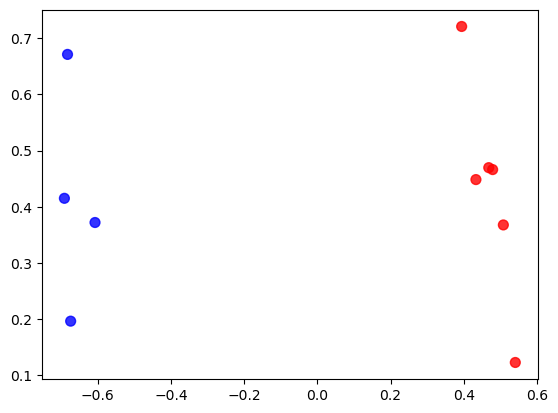

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

# Generate a mapping
# Here we're using the total principal component method,
# find out about others through the docstring for this function
mapx, mapy = phClust3.create_mapping()
print(help(phClust3.create_mapping))

# By this scatter plot we can see that the points are indeed all distinctly split into two groups, corresponding
# to their clustering (here marked by colour)
plt.scatter(mapx, mapy, c=['red' if c==1 else 'blue' for c in clust3_inds], s=50, alpha=0.8)